Задача - multi-label классификация - освежить память что это значит (https://scikit-learn.org/stable/modules/multiclass.html).

Тартеты: 14 последних колонок - df.iloc[:,-14:]

Метрика: Micro averaged F1. Хорошо бы оценивать качество с помощью кросс-валидации.

- Построить baseline с использованием линейной модели из scikit-learn


- Чистый Tensorflow

Построить линейную модель для решения этой задачи. Можно взять существующий код из блокнота Tensorflow examples 1.ipynb и переделать.


- Keras

Сделать тоже самое как и в Tensorflow но использовав чистый Keras

Добавить слоёв и нелинейностей, сравнить качество моделей


In [1]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn
!pip install --upgrade tensorflow
!pip install --upgrade keras

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.1)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.12.0)
Requirement already up-to-date: keras in c:\anaconda\lib\site-packages (2.2.4)


In [2]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from tqdm import tqdm
from time import time

sns.set(font_scale=1.3)

seed = 321

%matplotlib inline

In [3]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score 
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.manifold import TSNE

In [82]:
import tensorflow as tf

In [83]:
import keras
import json
import operator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.metrics import binary_accuracy,categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json
from keras import regularizers

#### EDA.

read first ten row to understand, how to parse data.

In [6]:
df = pd.read_csv('data/multilabel_dataset.csv', nrows = 15)

In [7]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0
5,0.003286,-0.023601,-0.023104,-0.064171,-0.017719,-0.113510,-0.035212,-0.077675,-0.024348,-0.012458,...,0,0,0,0,0,1,1,1,1,0
6,0.076606,-0.025478,0.072419,-0.065383,0.123539,0.120130,0.102248,0.008324,0.094147,-0.014666,...,0,0,0,0,0,0,0,1,1,0
7,-0.106801,-0.069277,-0.132254,-0.099246,-0.188413,-0.110359,-0.155120,-0.168094,-0.182473,0.023208,...,0,0,0,0,0,0,0,1,1,0
8,0.177650,0.136159,0.153211,0.190312,0.158541,0.219521,0.079914,0.232238,0.127932,0.089142,...,0,0,0,0,0,0,0,1,1,0
9,0.122075,-0.055828,-0.034775,-0.039235,0.075027,0.087308,0.088062,0.122385,0.091848,-0.099132,...,0,0,0,0,0,0,0,1,1,0


In [8]:
df = pd.read_csv('data/multilabel_dataset.csv', sep = ',', header = 0, decimal = '.')

- types of features.+
- Count Na.+
- Values distribution.+
- train test split or Separate target from whole dataset.+
- pipeline.
- eval score function.

- shape, types of features (+ value counts).

In [9]:
df.shape

(2417, 117)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Columns: 117 entries, feature_0 to target_13
dtypes: float64(103), int64(14)
memory usage: 2.2 MB


In [11]:
df.head(n=7)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0
5,0.003286,-0.023601,-0.023104,-0.064171,-0.017719,-0.113510,-0.035212,-0.077675,-0.024348,-0.012458,...,0,0,0,0,0,1,1,1,1,0
6,0.076606,-0.025478,0.072419,-0.065383,0.123539,0.120130,0.102248,0.008324,0.094147,-0.014666,...,0,0,0,0,0,0,0,1,1,0


In [12]:
df.tail(n=7)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
2410,0.061517,-0.051652,-0.058484,-0.181543,0.015579,-0.058696,0.043339,0.065145,0.044191,-0.030596,...,0,0,0,0,0,0,0,1,1,0
2411,0.032532,-0.015245,0.029789,0.046352,0.095598,0.005617,0.043168,0.006583,-0.033460,-0.022285,...,0,1,1,1,0,0,1,1,1,0
2412,-0.119784,0.001259,-0.123645,-0.015513,-0.059683,0.091032,-0.043302,0.229219,-0.071498,0.182709,...,0,0,0,0,0,0,0,0,0,0
2413,0.085327,0.058590,0.085268,-0.020897,0.068972,0.030125,0.078056,0.011346,0.052618,0.066093,...,0,0,0,0,0,0,0,1,1,0
2414,0.082526,-0.095571,-0.022019,-0.046793,-0.038360,0.041084,0.056509,0.011749,-0.029657,-0.012198,...,0,1,1,1,0,0,0,1,1,0
2415,-0.130830,0.008868,-0.009457,-0.058930,-0.041224,0.042269,0.117717,0.037388,-0.085563,0.136649,...,0,0,0,0,0,0,0,1,1,0
2416,-0.171578,-0.066536,0.168206,0.246831,0.079555,0.016528,-0.088908,-0.212926,-0.280230,-0.187064,...,0,0,0,0,0,0,0,1,1,0


In [13]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,0.298717,0.247000,0.177079,0.198593,0.073645,0.104675,0.119570,0.751345,0.744311,0.014067
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.457790,0.431356,0.381815,0.399024,0.261246,0.306198,0.324525,0.432323,0.436338,0.117792
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Данные уже отскейлены.

- Count Na.

In [14]:
#pprint()
list_NAs = df.isna().sum()

In [15]:
list_NAs[list_NAs != 0]

Series([], dtype: int64)

- Values distribution.

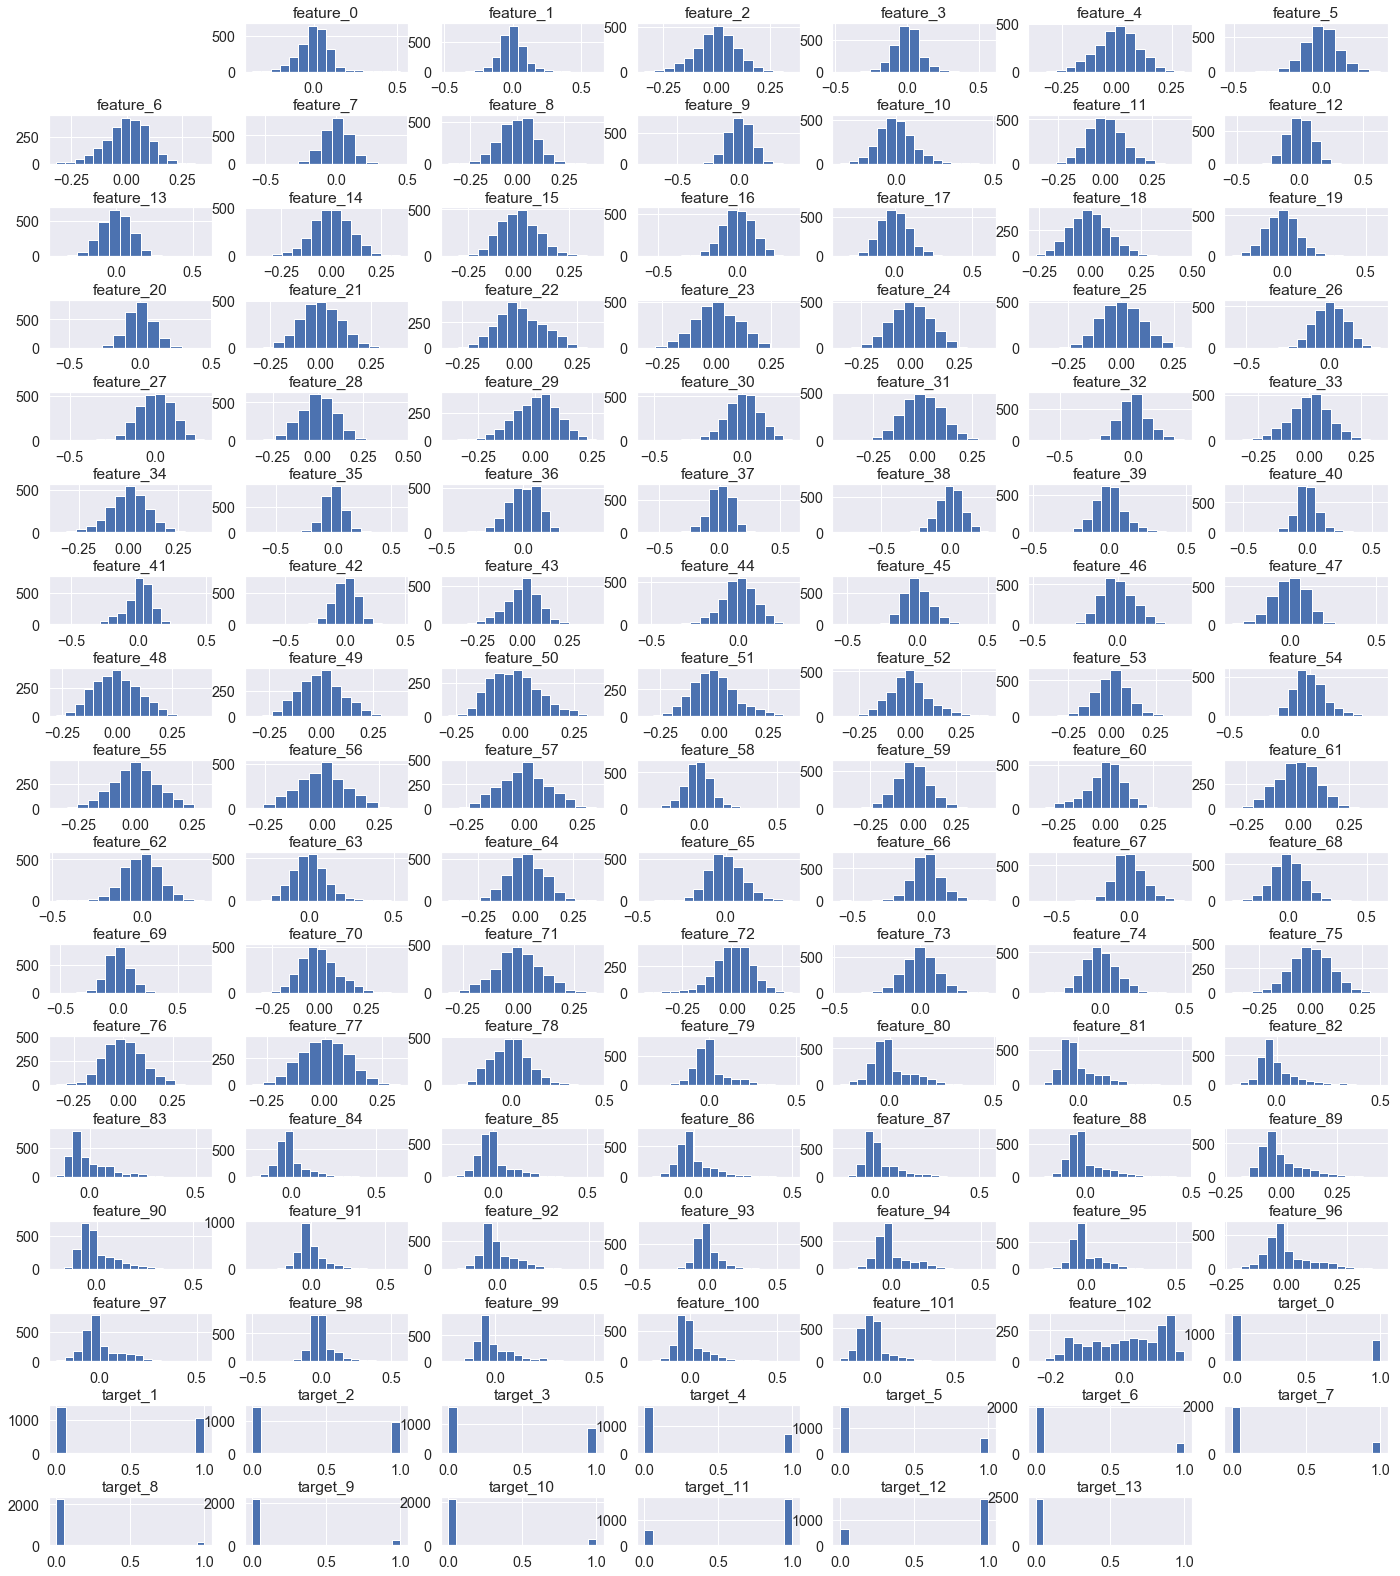

In [16]:
plt.figure(figsize=(24, 28))
for i, col in enumerate(df.columns):
    plt.subplot(17,7,i+2)
    plt.hist(df[col],bins='doane')
    plt.subplots_adjust(hspace = 0.9)
    plt.title(col);

- Separate target from whole dataset.

In [17]:
y = df.iloc[:,-14:]

In [18]:
for i, col in enumerate(y.columns[:-1]):
    print(y[col].value_counts())

0    1655
1     762
Name: target_0, dtype: int64
0    1379
1    1038
Name: target_1, dtype: int64
0    1434
1     983
Name: target_2, dtype: int64
0    1555
1     862
Name: target_3, dtype: int64
0    1695
1     722
Name: target_4, dtype: int64
0    1820
1     597
Name: target_5, dtype: int64
0    1989
1     428
Name: target_6, dtype: int64
0    1937
1     480
Name: target_7, dtype: int64
0    2239
1     178
Name: target_8, dtype: int64
0    2164
1     253
Name: target_9, dtype: int64
0    2128
1     289
Name: target_10, dtype: int64
1    1816
0     601
Name: target_11, dtype: int64
1    1799
0     618
Name: target_12, dtype: int64


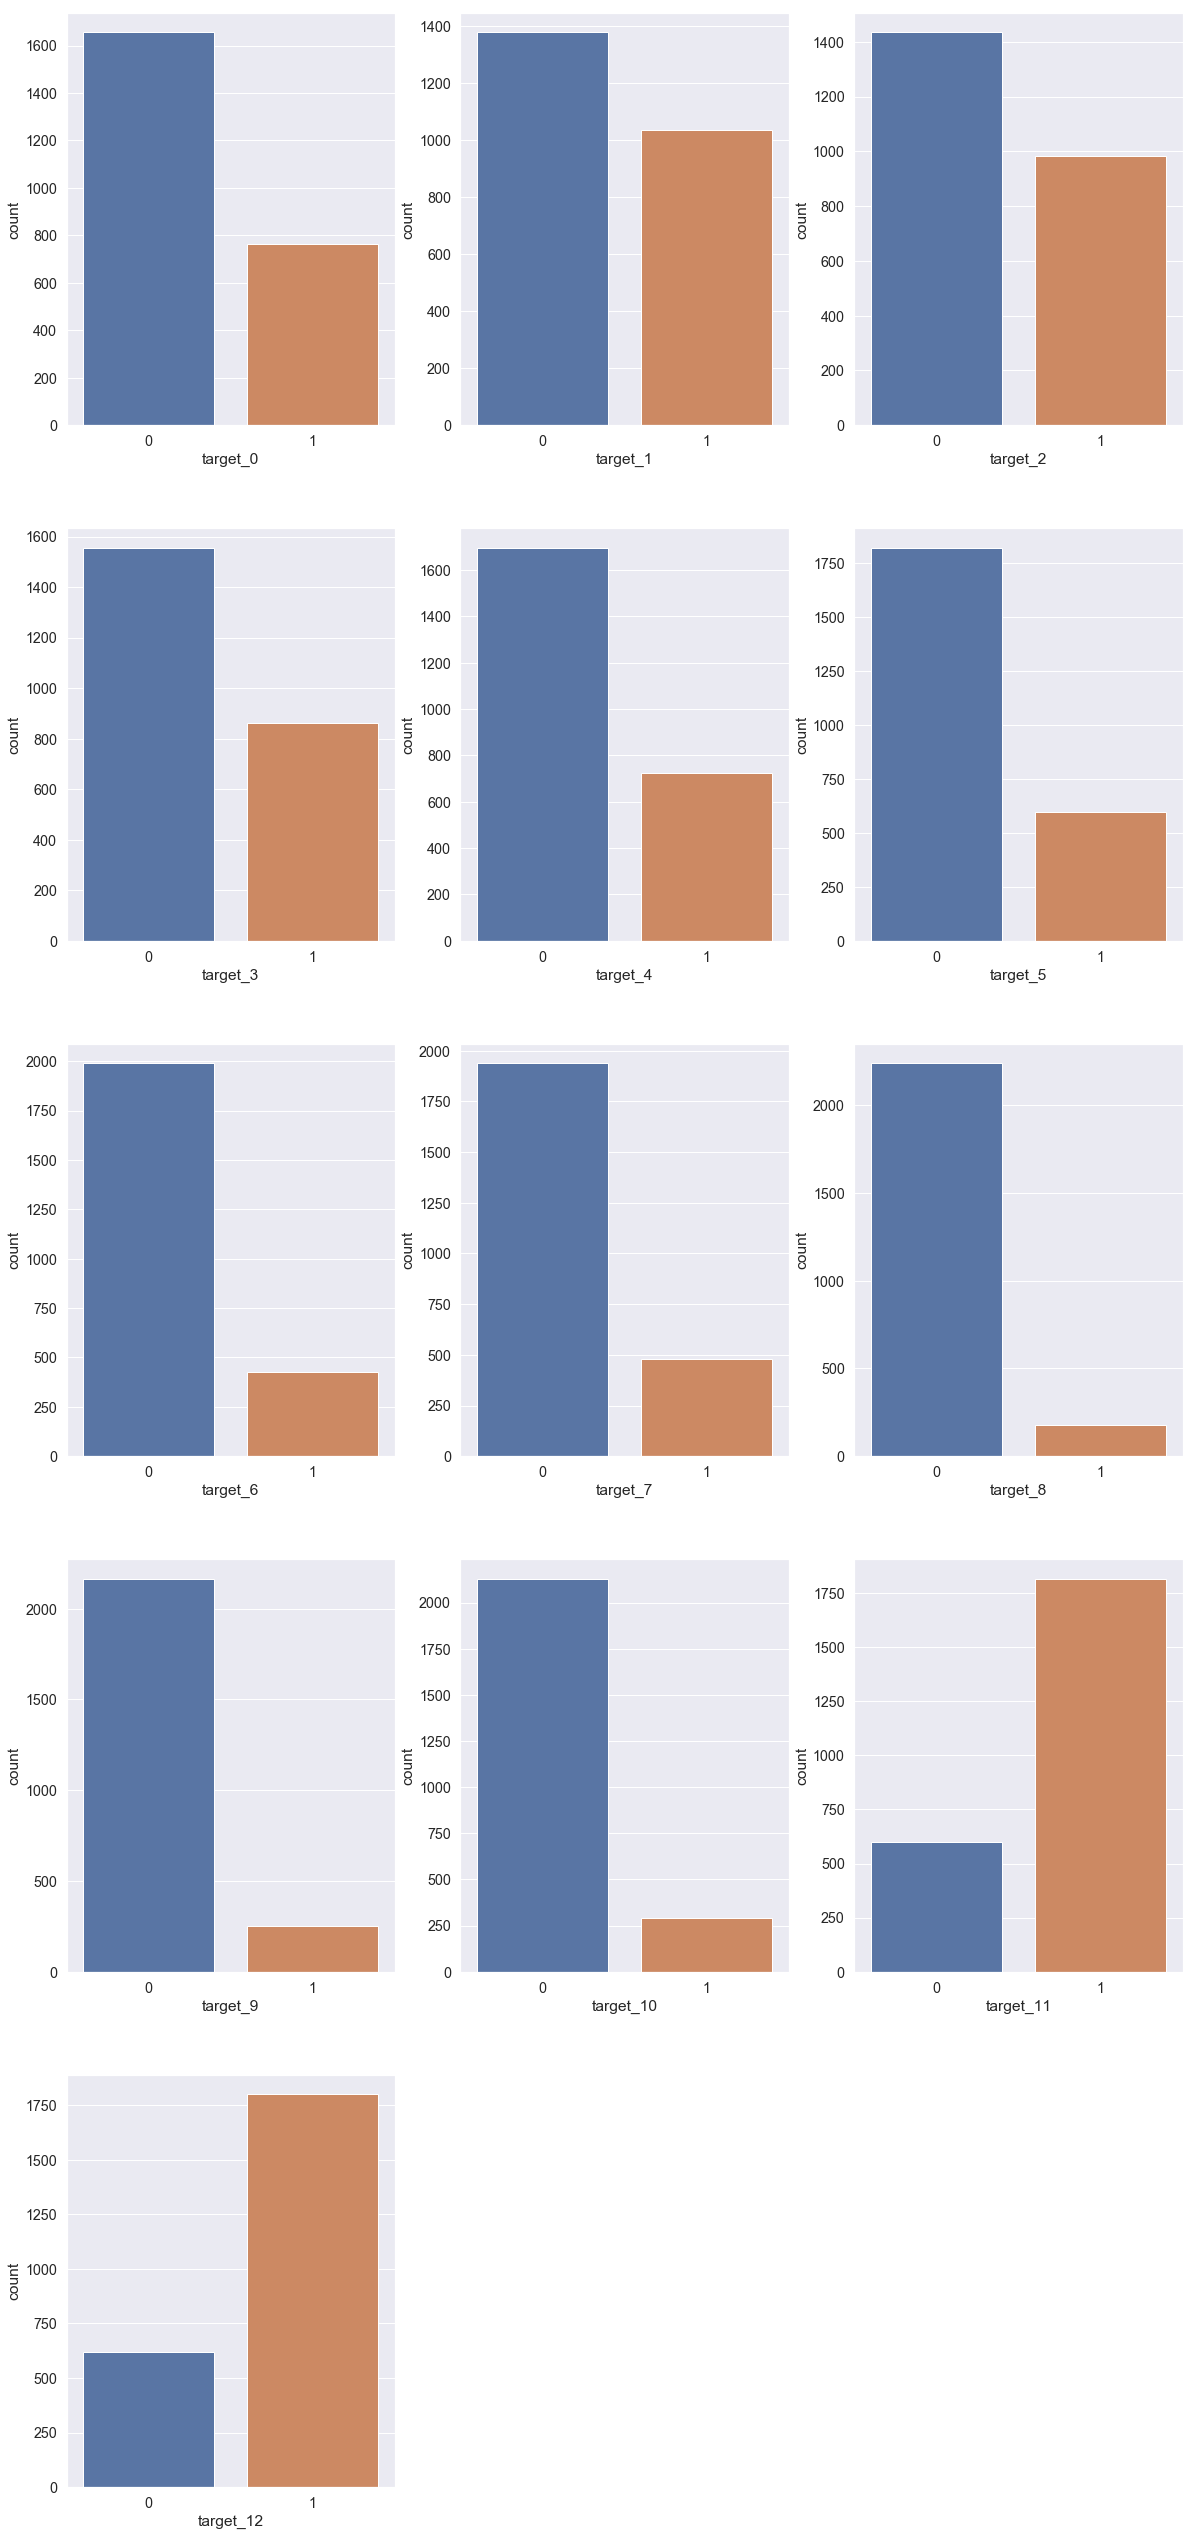

In [19]:
plt.figure(figsize=(20, 55)) 
for i, col in enumerate(y.columns[:-1]):# выводим все величины, кроме последней (целевой, ее будем рассматривать отдельно)
    plt.subplot(6,3,i+1)
    sns.countplot(x=y[col], data=y)
    plt.subplots_adjust(hspace = 0.25)

train/test split

In [20]:
columns_to_drop = df.columns
result = [k for k in columns_to_drop if 'target' in k]

In [21]:
df.drop(result, axis = 1, inplace = True)

Pay attention to shuffle = True

In [74]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = seed, test_size=0.3, shuffle=True)

In [75]:
x_train.shape

(1691, 103)

In [76]:
x_test.shape

(726, 103)

In [77]:
y_train.shape

(1691, 14)

In [78]:
y_test.shape

(726, 14)

#### Baseline.

with cross-validation and hyperparameters search.

In [79]:
skv = KFold(n_splits = 3,random_state=seed, shuffle=True)

Используется разбиение на 3 фолда, чтобы ускорить проведение обучения, в ином случае количество фолдов следует увеличить.

In [28]:
params = {
    'multi_class' : 'multinomial',
    'solver' : 'newton-cg',
    'random_state' : seed, 
    'max_iter' : 10e3,
    'penalty' : 'l2',
    'class_weight' : 'balanced'  
    
}

In [29]:
def create_estimator(estimator):
    return estimator

In [30]:
def create_cv_plot(estimator):
    alphas = estimator.cv_results_['param_estimator__C'].data
    scores = estimator.cv_results_['mean_test_score']
    combined = pd.DataFrame({'alpha':alphas, 'score':scores})
    plt.figure(figsize=(18, 10))

    plt.plot(combined.alpha[0:20], combined.score[0:20],'go-')
    plt.grid(True)
    plt.title('C and metrics plot')
    plt.xlabel('C values') 
    plt.ylabel('F1 micro')

#create_cv_plot(bclf)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   24.0s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   20.4s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.3s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.0s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.5s finished


[[0.60909570857530737, 0.57024508111839833, {'estimator__C': 1.5}],
 [0.6048728813559322, 0.53296030774610936, {'estimator__C': 1}],
 [0.60838537020517391, 0.54784437434279709, {'estimator__C': 1.5}],
 [0.60769750168804859, 0.54358623051892441, {'estimator__C': 1.5}],
 [0.61251784506724782, 0.5529349175385706, {'estimator__C': 1.5}]]

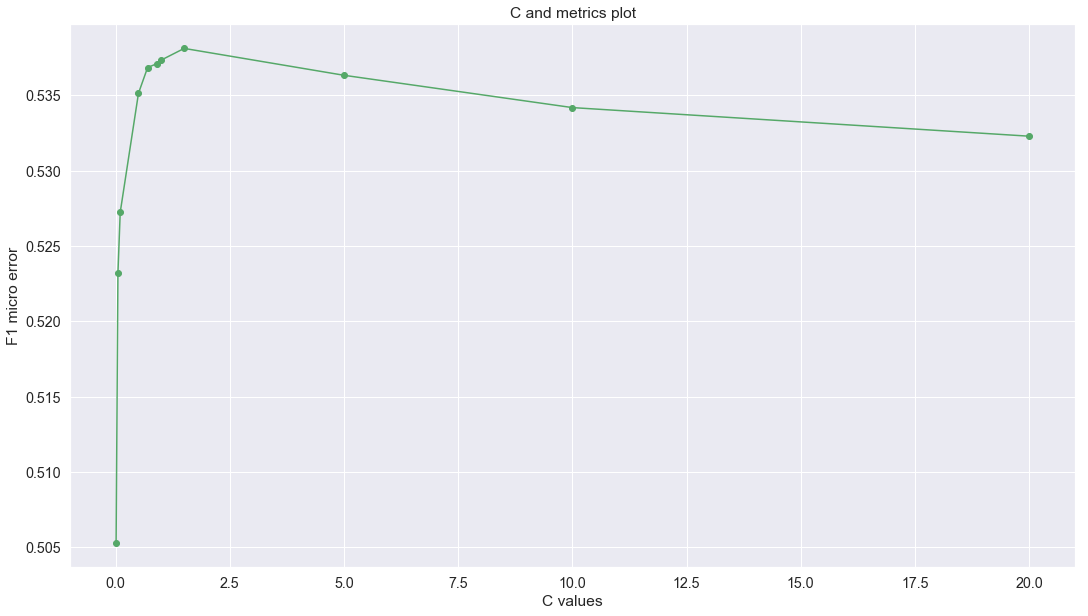

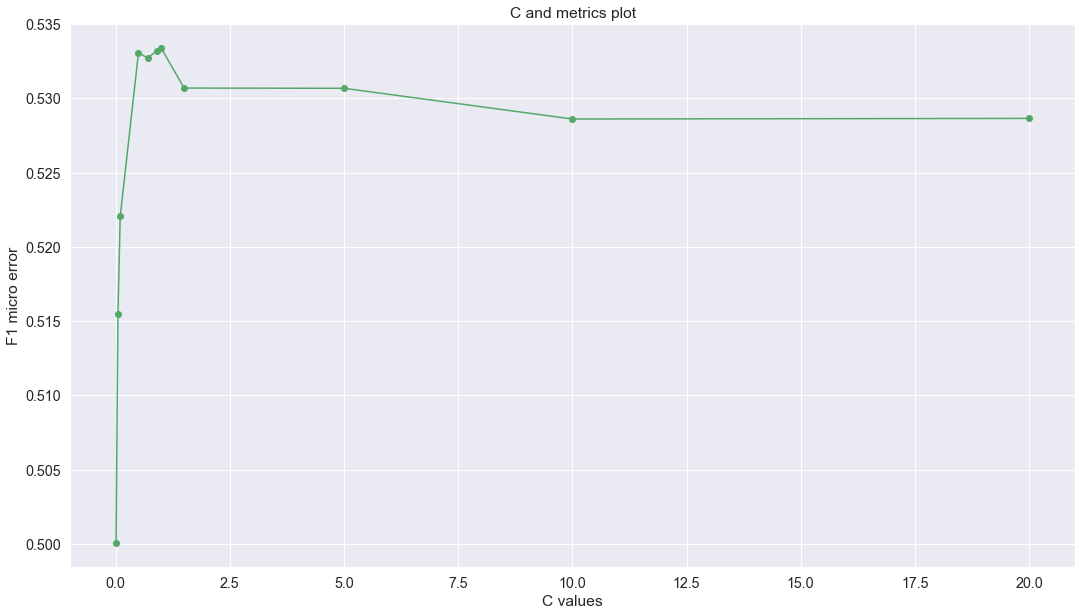

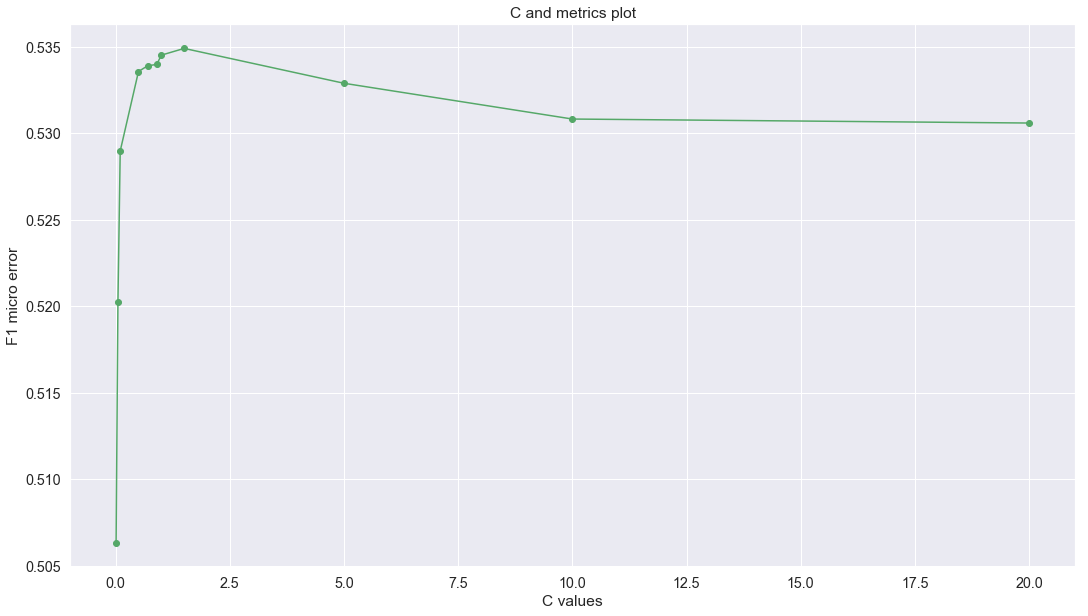

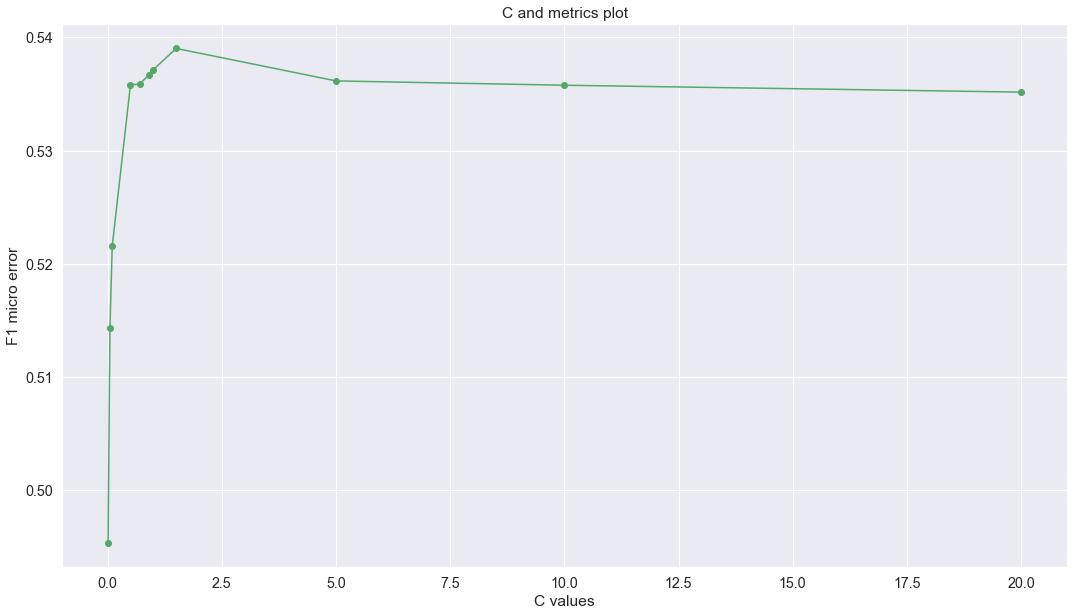

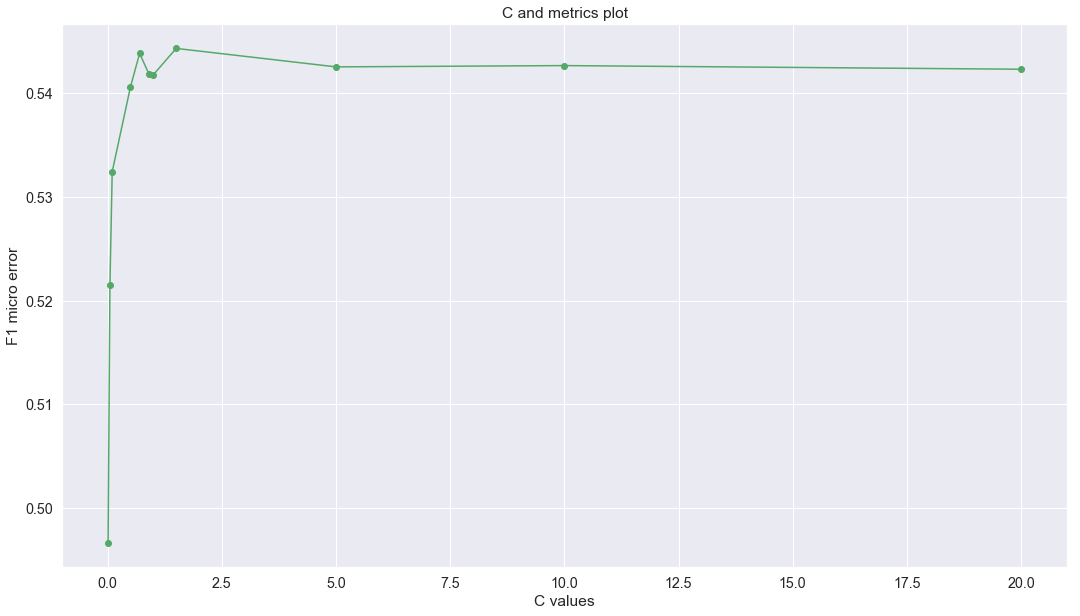

In [31]:
results_list = []
for train, test in skv.split(df,y):
    #print("%s %s" % (train.shape, test.shape))   
    X_val, y_val = df.iloc[train], y.iloc[train]
    x_train, x_test, y_train, y_test = train_test_split(X_val, y_val, random_state = seed, test_size=0.3, shuffle=True)
    
    clf_log = create_estimator(OneVsRestClassifier(LogisticRegression(**params), n_jobs = -1))
    #clf_log.fit(x_train,y_train)
    
    skv_gs = KFold(n_splits = 3,random_state=seed, shuffle=True)
    my_scorer = make_scorer(f1_score, average='micro')
    tuned_parameters = [{
        'estimator__C': [0.01, 0.05, 0.1, 0.5, 0.7, 0.9, 1, 1.5, 5, 10, 20]
                    }]
    bclf = GridSearchCV(clf_log, tuned_parameters,
                        scoring=my_scorer, cv=skv, verbose=8, n_jobs=-1,refit='f1_score')

    bclf.fit(x_train, y_train)
    #clf_log.estimator.C = (bclf.best_params_['estimator__C'])
    #Call predict on the estimator with the best found parameters.
    
    #create_cv_plot(bclf)
    
    y_pred_train = bclf.predict(x_train)
    y_pred_test = bclf.predict(x_test)
    f1_train = f1_score(y_train,y_pred_train,average='micro')
    f1_test = f1_score(y_test,y_pred_test,average='micro')
    results_list.append([f1_train , f1_test, bclf.best_params_]) 

results_list  

Вывод:


#### Tensorflow.

- написать про кросс валидацию
- написать про кривой ф1-скор
- боль!

In [33]:
# Step 1: define parameters
tf.logging.set_verbosity(tf.logging.ERROR)
tf.reset_default_graph()

# Define paramaters for the model
learning_rate = 0.01
batch_size = 128
n_epochs = 20

In [61]:
# Step 2: create placeholders for features and labels
X = tf.placeholder(tf.float32, [batch_size, 103], name='feature_data') # 1x103 is a number of features, 0-102
Y = tf.placeholder(tf.float32, [batch_size, 14], name='label') # 1x14 is a number of unique labels, 0-13, int 32

In [62]:
# Step 3: create weights and bias
# w is initialized to random variables with mean of 0, stddev of 0.01
# b is initialized to 0
# shape of w depends on the dimension of X and Y so that Y = tf.matmul(X, w)
# shape of b depends on Y
#w = tf.get_variable(name='weights', shape=(784, 10), initializer=tf.random_normal_initializer())
#b = tf.get_variable(name='bias', shape=(1, 10), initializer=tf.zeros_initializer())
w = tf.get_variable(name='weights', shape=(103, 14), initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
b = tf.get_variable(name='bias', shape=(1, 14), initializer=tf.zeros_initializer())

In [63]:
# Step 4: build model
# construct model to predict sigmoid(W.T * X + b)
#v1
logits = tf.matmul(X, w) + b 

#v2
#logits_1 = tf.matmul(X, w) + b 
#logits =  tf.nn.sigmoid(logits_1)

#loss = tf.reduce_mean(-Y * tf.log(logits) - (1 - Y) * tf.log(1 - logits))

In [64]:
# Step 5: define loss function
# use cross entropy of sigmoid of logits as the loss function
entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y) #1
loss = tf.reduce_mean(entropy) 
#loss = tf.reduce_mean(tf.reduce_sum(entropy, axis=1)) #1

In [65]:
# Step 6: define training op
# using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [66]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data.iloc[idx]
    labels_shuffle = [labels.iloc[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

#X_batch, Y_batch = next_batch(batch_size, x_test, y_test)
#print (X_batch, Y_batch)

In [67]:
def tf_f1_score(y_true, y_pred):
    print (y_pred)
    """Computes 3 different f1 scores, micro macro
    weighted.
    micro: f1 score accross the classes, as 1
    macro: mean of f1 scores per class
    weighted: weighted average of f1 scores per class,
            weighted from the support of each class


    Args:
        y_true (Tensor): labels, with shape (batch, num_classes)
        y_pred (Tensor): model's predictions, same shape as y_true

    Returns:
        tuple(Tensor): (micro, macro, weighted)
                    tuple of the computed f1 scores
    """

    f1s = [0, 0, 0]

    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    for i, axis in enumerate([None, 0]):
        print (i)
        TP = tf.count_nonzero(y_pred * y_true, axis=axis)
        FP = tf.count_nonzero(y_pred * (y_true - 1), axis=axis)
        FN = tf.count_nonzero((y_pred - 1) * y_true, axis=axis)

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)

        f1s[i] = tf.reduce_mean(f1)

    weights = tf.reduce_sum(y_true, axis=0)
    weights /= tf.reduce_sum(weights)

    f1s[2] = tf.reduce_sum(f1 * weights)

    micro, macro, weighted = f1s
    return micro, macro, weighted

In [128]:
# Step 7: calculate accuracy with test set
preds = tf.math.round(tf.nn.sigmoid(logits)) # 1
#correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1)) #1
#accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32)) #1
precis = tf.metrics.precision(labels=Y,predictions=preds)
recall = tf.metrics.recall(labels=Y,predictions=preds)

TP = tf.count_nonzero(Y*preds)
FP = tf.count_nonzero(preds * (Y - 1))
FN = tf.count_nonzero((preds - 1) * Y)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

prediction_list = []
batches_list = []


with tf.Session() as sess:
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    n_batches = int(x_train.shape[0]/batch_size)
    print ("Number of train batches", n_batches)
    # train the model n_epochs times
    for i in range(n_epochs): 
        total_loss = 0

        for j in range(n_batches):
            X_batch, Y_batch = next_batch(batch_size, x_train, y_train)
            _, loss_batch = sess.run([optimizer, loss], {X: X_batch, Y:Y_batch}) 
            total_loss += loss_batch
        print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))

    # test the model
    n_batches = int(x_test.shape[0]/batch_size)
    total_correct_preds,accuracy_batch = 0,0
    print ("Number of test batches", n_batches)
    
    #results = sess.run(preds, feed_dict = {X_valid: x_test, Y_valid:y_test})

    for i in range(n_batches):
        X_batch, Y_batch = next_batch(batch_size, x_test, y_test)
        #accuracy_batch = sess.run(f1, feed_dict = {X: X_batch, Y:Y_batch})
        predictions = sess.run(preds, feed_dict = {X: X_batch, Y:Y_batch})
        
        prediction_list.append(predictions)
        batches_list.append(Y_batch)

Number of train batches 13
Average loss epoch 0: 0.6701766619315515
Average loss epoch 1: 0.6241844892501831
Average loss epoch 2: 0.5909076424745413
Average loss epoch 3: 0.5672050622793344
Average loss epoch 4: 0.5381907087105972
Average loss epoch 5: 0.5262141181872442
Average loss epoch 6: 0.5095629279430096
Average loss epoch 7: 0.4960736632347107
Average loss epoch 8: 0.4904223818045396
Average loss epoch 9: 0.4805605044731727
Average loss epoch 10: 0.4702287522646097
Average loss epoch 11: 0.4687171532557561
Average loss epoch 12: 0.4538507415698125
Average loss epoch 13: 0.44980881764338565
Average loss epoch 14: 0.44853312923358035
Average loss epoch 15: 0.4441036811241737
Average loss epoch 16: 0.4405663013458252
Average loss epoch 17: 0.4430747857460609
Average loss epoch 18: 0.4312121615960048
Average loss epoch 19: 0.44288997466747576
Number of test batches 5


In [130]:
prediction_list = [l.tolist() for l in prediction_list]
batches_list = [l.tolist() for l in batches_list]

In [136]:
result = []
for x, y in zip(batches_list, prediction_list):
    result.append(f1_score(np.asarray(x),np.asarray(y),average='micro'))

#f1_score(y_val,y_pred_test,average='micro')

In [137]:
np.mean(result)

0.61998852007323302

#### Keras.

V1, tensorflow analog.

Сделать тоже самое как и в Tensorflow но использовав чистый Keras.

In [90]:
# Define paramaters for the model
batch_size = 128
n_epochs = 30
from keras import backend as K
K.clear_session()

In [112]:
def create_model(df, y, n_split, path):
    x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = seed, test_size=0.3, shuffle=True)
    model = Sequential()

    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]

    model.add(Dense(activation='sigmoid', output_dim = output_dim,  input_dim = input_dim))
    
    earlyStopping = EarlyStopping(monitor='val_acc', patience=5, verbose=2, mode='max',restore_best_weights=True)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

    history_model = model.fit(x_train, y_train,
              batch_size=batch_size, epochs=50,
              validation_data = (x_test, y_test),verbose=2,callbacks=[earlyStopping])
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(path + "model_" + str(n_split) + ".json", "w") as json_file:
        json_file.write(model_json)
        
    with open(path + "history_" + str(n_split) + ".json", 'w') as f:
        json.dump(history_model.history, f)
    
    # serialize weights to HDF5
    model.save_weights(path + "model_" + str(n_split) + ".h5")
    print("Saved model to disk")
    
    return model

In [113]:
threshold = 0.5
n_split = 0
results = []
path = "models/simple_keras_logit/" 

for train, test in skv.split(df,y):
    n_split +=1
    #print("%s %s" % (train.shape, test.shape))   
    X_val, y_val = df.iloc[train], y.iloc[train]
    model = create_model(X_val, y_val, n_split, path)

    y_pred_test = model.predict(X_val)
    y_pred_test[y_pred_test>=threshold] = 1
    y_pred_test[y_pred_test<threshold] = 0
    
    results.append([n_split,f1_score(y_val,y_pred_test,average='micro')])

    #print('Classification report\n')
    #print(classification_report(y_val, y_pred_test))  

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=103, units=14)`
  


Train on 1353 samples, validate on 580 samples
Epoch 1/50
 - 2s - loss: 11.1139 - acc: 0.0769 - val_loss: 11.2843 - val_acc: 0.0897
Epoch 2/50
 - 0s - loss: 11.0893 - acc: 0.0953 - val_loss: 11.2602 - val_acc: 0.1069
Epoch 3/50
 - 0s - loss: 11.0655 - acc: 0.1175 - val_loss: 11.2363 - val_acc: 0.1310
Epoch 4/50
 - 0s - loss: 11.0424 - acc: 0.1449 - val_loss: 11.2135 - val_acc: 0.1379
Epoch 5/50
 - 0s - loss: 11.0199 - acc: 0.1545 - val_loss: 11.1914 - val_acc: 0.1414
Epoch 6/50
 - 0s - loss: 10.9980 - acc: 0.1670 - val_loss: 11.1696 - val_acc: 0.1500
Epoch 7/50
 - 0s - loss: 10.9769 - acc: 0.1737 - val_loss: 11.1483 - val_acc: 0.1638
Epoch 8/50
 - 0s - loss: 10.9557 - acc: 0.1833 - val_loss: 11.1276 - val_acc: 0.1638
Epoch 9/50
 - 0s - loss: 10.9351 - acc: 0.1885 - val_loss: 11.1074 - val_acc: 0.1724
Epoch 10/50
 - 0s - loss: 10.9148 - acc: 0.1936 - val_loss: 11.0878 - val_acc: 0.1810
Epoch 11/50
 - 0s - loss: 10.8951 - acc: 0.1966 - val_loss: 11.0685 - val_acc: 0.1810
Epoch 12/50
 - 0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=103, units=14)`
  


Train on 1353 samples, validate on 580 samples
Epoch 1/50
 - 2s - loss: 11.1565 - acc: 0.0436 - val_loss: 11.0867 - val_acc: 0.0672
Epoch 2/50
 - 0s - loss: 11.1305 - acc: 0.0584 - val_loss: 11.0641 - val_acc: 0.0707
Epoch 3/50
 - 0s - loss: 11.1055 - acc: 0.0650 - val_loss: 11.0422 - val_acc: 0.0966
Epoch 4/50
 - 0s - loss: 11.0811 - acc: 0.0798 - val_loss: 11.0210 - val_acc: 0.1155
Epoch 5/50
 - 0s - loss: 11.0575 - acc: 0.0983 - val_loss: 11.0001 - val_acc: 0.1190
Epoch 6/50
 - 0s - loss: 11.0344 - acc: 0.1064 - val_loss: 10.9799 - val_acc: 0.1414
Epoch 7/50
 - 0s - loss: 11.0118 - acc: 0.1205 - val_loss: 10.9602 - val_acc: 0.1466
Epoch 8/50
 - 0s - loss: 10.9900 - acc: 0.1323 - val_loss: 10.9409 - val_acc: 0.1534
Epoch 9/50
 - 0s - loss: 10.9687 - acc: 0.1390 - val_loss: 10.9221 - val_acc: 0.1621
Epoch 10/50
 - 0s - loss: 10.9477 - acc: 0.1493 - val_loss: 10.9039 - val_acc: 0.1603
Epoch 11/50
 - 0s - loss: 10.9274 - acc: 0.1574 - val_loss: 10.8861 - val_acc: 0.1707
Epoch 12/50
 - 0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=103, units=14)`
  


Train on 1353 samples, validate on 581 samples
Epoch 1/50
 - 2s - loss: 11.3195 - acc: 0.0739 - val_loss: 11.1962 - val_acc: 0.0843
Epoch 2/50
 - 0s - loss: 11.2944 - acc: 0.0990 - val_loss: 11.1740 - val_acc: 0.1102
Epoch 3/50
 - 0s - loss: 11.2700 - acc: 0.1264 - val_loss: 11.1529 - val_acc: 0.1274
Epoch 4/50
 - 0s - loss: 11.2466 - acc: 0.1434 - val_loss: 11.1321 - val_acc: 0.1463
Epoch 5/50
 - 0s - loss: 11.2238 - acc: 0.1508 - val_loss: 11.1117 - val_acc: 0.1446
Epoch 6/50
 - 0s - loss: 11.2012 - acc: 0.1611 - val_loss: 11.0920 - val_acc: 0.1566
Epoch 7/50
 - 0s - loss: 11.1794 - acc: 0.1766 - val_loss: 11.0726 - val_acc: 0.1687
Epoch 8/50
 - 0s - loss: 11.1581 - acc: 0.1803 - val_loss: 11.0536 - val_acc: 0.1807
Epoch 9/50
 - 0s - loss: 11.1371 - acc: 0.1811 - val_loss: 11.0350 - val_acc: 0.1876
Epoch 10/50
 - 0s - loss: 11.1166 - acc: 0.1885 - val_loss: 11.0168 - val_acc: 0.1928
Epoch 11/50
 - 0s - loss: 11.0966 - acc: 0.1922 - val_loss: 10.9990 - val_acc: 0.1945
Epoch 12/50
 - 0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=103, units=14)`
  


Train on 1353 samples, validate on 581 samples
Epoch 1/50
 - 2s - loss: 11.1617 - acc: 0.1101 - val_loss: 11.2149 - val_acc: 0.1256
Epoch 2/50
 - 0s - loss: 11.1353 - acc: 0.1375 - val_loss: 11.1927 - val_acc: 0.1446
Epoch 3/50
 - 0s - loss: 11.1112 - acc: 0.1537 - val_loss: 11.1709 - val_acc: 0.1515
Epoch 4/50
 - 0s - loss: 11.0874 - acc: 0.1678 - val_loss: 11.1500 - val_acc: 0.1652
Epoch 5/50
 - 0s - loss: 11.0636 - acc: 0.1781 - val_loss: 11.1296 - val_acc: 0.1824
Epoch 6/50
 - 0s - loss: 11.0411 - acc: 0.1936 - val_loss: 11.1096 - val_acc: 0.1876
Epoch 7/50
 - 0s - loss: 11.0192 - acc: 0.2003 - val_loss: 11.0901 - val_acc: 0.2014
Epoch 8/50
 - 0s - loss: 10.9975 - acc: 0.2151 - val_loss: 11.0710 - val_acc: 0.2186
Epoch 9/50
 - 0s - loss: 10.9763 - acc: 0.2210 - val_loss: 11.0524 - val_acc: 0.2289
Epoch 10/50
 - 0s - loss: 10.9557 - acc: 0.2203 - val_loss: 11.0340 - val_acc: 0.2324
Epoch 11/50
 - 0s - loss: 10.9355 - acc: 0.2306 - val_loss: 11.0161 - val_acc: 0.2324
Epoch 12/50
 - 0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=103, units=14)`
  


Train on 1353 samples, validate on 581 samples
Epoch 1/50
 - 2s - loss: 11.2100 - acc: 0.0865 - val_loss: 10.9533 - val_acc: 0.1050
Epoch 2/50
 - 0s - loss: 11.1823 - acc: 0.1005 - val_loss: 10.9284 - val_acc: 0.1119
Epoch 3/50
 - 0s - loss: 11.1564 - acc: 0.1094 - val_loss: 10.9042 - val_acc: 0.1222
Epoch 4/50
 - 0s - loss: 11.1309 - acc: 0.1197 - val_loss: 10.8810 - val_acc: 0.1274
Epoch 5/50
 - 0s - loss: 11.1061 - acc: 0.1375 - val_loss: 10.8581 - val_acc: 0.1377
Epoch 6/50
 - 0s - loss: 11.0822 - acc: 0.1471 - val_loss: 10.8359 - val_acc: 0.1429
Epoch 7/50
 - 0s - loss: 11.0589 - acc: 0.1508 - val_loss: 10.8142 - val_acc: 0.1549
Epoch 8/50
 - 0s - loss: 11.0359 - acc: 0.1626 - val_loss: 10.7932 - val_acc: 0.1670
Epoch 9/50
 - 0s - loss: 11.0139 - acc: 0.1744 - val_loss: 10.7727 - val_acc: 0.1756
Epoch 10/50
 - 0s - loss: 10.9921 - acc: 0.1863 - val_loss: 10.7526 - val_acc: 0.1738
Epoch 11/50
 - 0s - loss: 10.9707 - acc: 0.1922 - val_loss: 10.7328 - val_acc: 0.1842
Epoch 12/50
 - 0

In [118]:
results

{1: 0.61671203328026292,
 2: 0.60004119040263626,
 3: 0.60321471896482004,
 4: 0.57175443816324512,
 5: 0.62570577969407659}

In [119]:
results = dict(results)
top_model = max(results.items(), key=operator.itemgetter(1))[0]
top_model

5

In [120]:
# load json and create model
json_file = open(path +"model_" + str(top_model) + ".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path +"model_" + str(top_model) + ".h5")
print("Loaded model from disk")

#load history
json_file = open(path +"history_" + str(top_model) + ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

Loaded model from disk


In [121]:
y_predicted_scores = loaded_model.predict(x_test)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report

              precision    recall  f1-score   support

           0       0.54      0.67      0.60       236
           1       0.48      0.88      0.62       304
           2       0.48      0.88      0.62       276
           3       0.52      0.80      0.63       257
           4       0.54      0.55      0.54       245
           5       0.48      0.46      0.47       197
           6       0.28      0.31      0.29       136
           7       0.30      0.36      0.32       149
           8       0.09      0.14      0.11        63
           9       0.18      0.37      0.24        76
          10       0.18      0.28      0.22        78
          11       0.77      0.97      0.86       552
          12       0.76      0.97      0.86       546
          13       0.03      0.18      0.05        11

   micro avg       0.53      0.74      0.62      3126
   macro avg       0.40      0.56      0.46      3126
weighted avg       0.55      0.74      0.63      3126
 sa

Plot resutls.

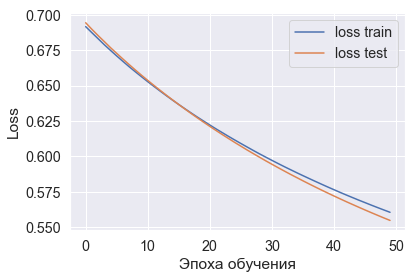

In [110]:
plt.plot(loaded_history_json['val_loss'], 
         label='loss train')
plt.plot(loaded_history_json['loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

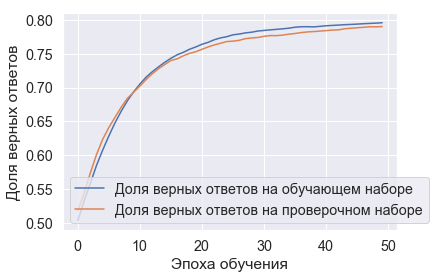

In [111]:
plt.plot(loaded_history_json['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(loaded_history_json['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Вывод: наилучший скор в данной модели 0.62, который совпал со скором в tensorflow модели. 

V2

In [37]:
#temporaly disabled due to move notebook to colab
#block code for model visualisation and save to png
'''
import pydot_ng as pydot
import graphviz
import pydotplus
from IPython.display import SVG
from keras.utils import model_to_dot
import matplotlib.image as mpimg

from keras.utils import plot_model as pmd
pmd(model,to_file='model.png' ,show_shapes = True)
img = mpimg.imread('model.png')
plt.figure(figsize=(20, 10)) 
plt.imshow(img)
plt.show()
''';

Внесем в сеть следующие изменения:
- добавим Dropout, чтобы побороться с переобучением
- несколько дополнительных слоев.

In [90]:
# Define paramaters for the model
batch_size = 128
n_epochs = 30

K.clear_session()

In [91]:
def create_model_imp(df, y, n_split, path):
    
    
    x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = seed, test_size=0.3, 
                                                        shuffle=True)
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    model = Sequential()
    # test
    model.add(Dense(input_dim= input_dim, units = 5000, activation='relu')) #units as output dim
    model.add(Dropout(0.1))
    model.add(Dense(input_dim = 5000, units = 2500, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(input_dim = 1000, units = 1600, activation='relu'))
    model.add(Dropout(0.2))
    # end test
    model.add(Dense(input_dim = 1600, units=14, activation='sigmoid'))
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    
    earlyStopping = EarlyStopping(monitor='val_acc', patience=5, verbose=2, mode='max',
                                  restore_best_weights=True,min_delta=0.001)
    
    history_model = model.fit(x_train, y_train,                   
                              batch_size=batch_size, 
                              epochs=n_epochs, 
                              validation_data = (x_test, y_test), 
                              verbose = 2,
                              callbacks=[earlyStopping])
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(path + "df_model_" + str(n_split) + ".json", "w") as json_file:
        json_file.write(model_json)
        
    with open(path + "df_history_" + str(n_split) + ".json", 'w') as f:
        json.dump(history_model.history, f)
    
    # serialize weights to HDF5
    model.save_weights(path + "df_model_" + str(n_split) + ".h5")
    print("Saved model to disk")
    
    return model

In [92]:
threshold = 0.5
n_split = 0
results = []
path = "models/advanced/"

for train, test in skv.split(df,y):
    n_split +=1
    #print("%s %s" % (train.shape, test.shape))   
    X_val, y_val = df.iloc[train], y.iloc[train]
    model = create_model_imp(X_val, y_val, n_split, path)

    y_pred_test = model.predict(X_val)
    y_pred_test[y_pred_test>=threshold] = 1
    y_pred_test[y_pred_test<threshold] = 0
    
    results.append([n_split,f1_score(y_val,y_pred_test,average='micro')]) 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000018085AE1EB8>>
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Anaconda\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 1651529351240
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000018083074898>>
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Anaconda\lib\site-packages\tensorflow\python\framework\errors_i

Train on 1353 samples, validate on 580 samples
Epoch 1/50
 - 9s - loss: 0.5378 - acc: 0.7358 - val_loss: 0.4728 - val_acc: 0.7818
Epoch 2/50
 - 7s - loss: 0.4592 - acc: 0.7898 - val_loss: 0.4461 - val_acc: 0.7969
Epoch 3/50
 - 7s - loss: 0.4276 - acc: 0.8076 - val_loss: 0.4375 - val_acc: 0.8004
Epoch 4/50
 - 7s - loss: 0.4005 - acc: 0.8175 - val_loss: 0.4266 - val_acc: 0.8071
Epoch 5/50
 - 8s - loss: 0.3691 - acc: 0.8325 - val_loss: 0.4339 - val_acc: 0.8060
Epoch 6/50
 - 9s - loss: 0.3331 - acc: 0.8541 - val_loss: 0.4602 - val_acc: 0.8038
Epoch 7/50
 - 9s - loss: 0.2891 - acc: 0.8769 - val_loss: 0.4832 - val_acc: 0.7975
Epoch 8/50
 - 8s - loss: 0.2409 - acc: 0.9027 - val_loss: 0.5199 - val_acc: 0.7994
Epoch 9/50
 - 8s - loss: 0.1966 - acc: 0.9208 - val_loss: 0.5667 - val_acc: 0.7990
Epoch 10/50
 - 7s - loss: 0.1567 - acc: 0.9403 - val_loss: 0.6260 - val_acc: 0.7890
Restoring model weights from the end of the best epoch
Epoch 00010: early stopping
Saved model to disk
Train on 1353 sampl

In [93]:
results

[[1, 0.69164530335896934],
 [2, 0.66375430235636745],
 [3, 0.69953755780527427],
 [4, 0.66903437646585806],
 [5, 0.72379696769940671]]

In [94]:
results = dict(results)
top_model = max(results.items(), key=operator.itemgetter(1))[0]
top_model

5

In [96]:
# load json and create model
json_file = open(path + "df_model_" + str(top_model) + ".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path + "df_model_" + str(top_model) + ".h5")
print("Loaded model from disk")

#load history
json_file = open(path + "df_history_" + str(top_model) + ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

Loaded model from disk


In [97]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5000)              520000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              12502500  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2500)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              4001600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1600)              0         
__________

In [98]:
y_predicted_scores = loaded_model.predict(x_test)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.87      0.60      0.71       236
           1       0.73      0.54      0.62       304
           2       0.76      0.81      0.78       276
           3       0.73      0.85      0.78       257
           4       0.85      0.65      0.73       245
           5       0.79      0.42      0.54       197
           6       0.79      0.08      0.15       136
           7       1.00      0.01      0.03       149
           8       0.00      0.00      0.00        63
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        78
          11       0.81      0.96      0.88       552
          12       0.79      0.97      0.87       546
          13       0.00      0.00      0.00        11

   micro avg       0.79      0.66      0.72      3126
   macro avg       0.58      0.42      0.43      3126
weighted avg       0.74      0.66      0.65      3126
 samples avg       0.77   

Plot resutls.

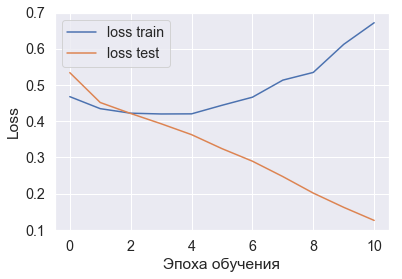

In [99]:
plt.plot(loaded_history_json['val_loss'], 
         label='loss train')
plt.plot(loaded_history_json['loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

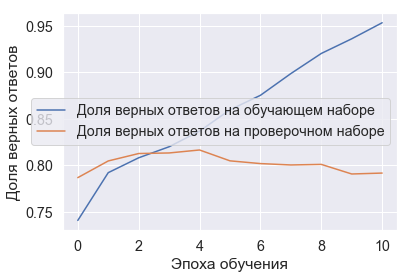

In [100]:
plt.plot(loaded_history_json['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(loaded_history_json['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

to do:
- plot calculate graph for tensorflow and keras 
- write comparison
